In [1]:
import numpy as np
import pandas as pd
from os import listdir, path, unlink
import pickle
import json
from typing import Union

import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from catboost import CatBoostClassifier

import neurokit2 as nk

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def read_pickle(path: str) -> pd.DataFrame:
    with open(path, mode='rb') as file:
        return pickle.load(file)
    
def dump_pickle(path: str, obj: pd.DataFrame):
    with open(path, mode='wb') as file:
        pickle.dump(obj, file)
        
def read_signal(path: str):
    with open(path, mode='rb') as file:
        return np.load(path, allow_pickle=True)

In [18]:
SAMPLING_RATE = 500

MAIN_PATH = '/Users/danil/AIIJC_FINAL'
DATA_PATH = path.join(MAIN_PATH, 'DATA')
TRAIN_PATH = path.join(DATA_PATH, 'train')
TEST_PATH = path.join(DATA_PATH, 'test')
TRAIN_META_PATH = path.join(TRAIN_PATH, 'train_meta.csv')
TRAIN_GTS_PATH = path.join(TRAIN_PATH, 'train_gts_final.csv')
TEST_META_PATH = path.join(TEST_PATH, 'test_meta.csv')

train_meta = pd.read_csv(TRAIN_META_PATH)
train_gts = pd.read_csv(TRAIN_GTS_PATH)
test_meta = pd.read_csv(TEST_META_PATH)

filenames_train = listdir(TRAIN_PATH)
filenames_test = listdir(TEST_PATH)
filenames_train = list(filter(lambda x: 'npy' in x, filenames_train))
filenames_test = list(filter(lambda x: 'npy' in x, filenames_test))

In [784]:
train_meta

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
3,52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
4,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,12488.0,66.0,1,NaN,NaN,0.0,0.0,CS100 3,2001-01-29 11:46:31,...,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21784_lr,records500/21000/21784_hr,21784_hr,3
2097,21795,10162.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-01-31 17:30:42,...,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21795_lr,records500/21000/21795_hr,21795_hr,3
2098,21825,11197.0,59.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-12 11:07:26,...,", alles,",NaN,NaN,NaN,NaN,3,records100/21000/21825_lr,records500/21000/21825_hr,21825_hr,1
2099,21831,11905.0,55.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-28 12:49:25,...,NaN,NaN,NaN,NaN,NaN,9,records100/21000/21831_lr,records500/21000/21831_hr,21831_hr,3


In [750]:
def get_data(train_data, test_data, k):
    train_data = train_data.merge(train_gts, on=['record_name'])
    target = ['перегородочный',
     'передний',
     'боковой',
     'передне-боковой',
     'передне-перегородочный',
     'нижний',
     'норма']

    new_train_data = pd.DataFrame()
    for c in train_data.columns:
        if 'model' in c:
            arr = np.array(train_data[c].tolist())
            for i in range(arr.shape[1]):
                if i % (arr.shape[1] // k) != 0:
                    continue
                new_train_data[c + '_' + str(i)] = arr[:, i]
        else:
            new_train_data[c] = train_data[c]

    new_test_data = pd.DataFrame()
    for c in test_data.columns:
        if 'model' in c:
            arr = np.array(test_data[c].tolist())
            for i in range(arr.shape[1]):
                if i % (arr.shape[1] // k) != 0:
                    continue
                new_test_data[c + '_' + str(i)] = arr[:, i]
        else:
            new_test_data[c] = test_data[c]

    train_data = new_train_data
    test_data = new_test_data
    x_columns = list(train_data.drop(columns=['record_name']).columns)
    x_columns = list(filter(lambda x: x not in target, x_columns))
    return train_data, test_data, x_columns

In [757]:
def train_catboosts(train_data, test_data, cols):
    global_clfs = {}
    global_params = {}

    grid = {
        'random_strength': [0.3, 0.4, 0.5],
        'depth': [4, 5],
        'l2_leaf_reg': [4, 5],
    }

    for t in tqdm(target):
        balance =  'Balanced' if t != 'норма' else 'SqrtBalanced'
        params = {
            'iterations': 5000,
            'early_stopping_rounds': 40,
            'auto_class_weights': balance,
            'learning_rate': 0.01,
        }
        res = []
        for rs in range(3):
            for d in range(2):
                for l2 in range(2):
                    params['random_strength'] = grid['random_strength'][rs]
                    params['depth'] = grid['depth'][d]
                    params['l2_leaf_reg'] = grid['l2_leaf_reg'][l2]

                    X, y = train_data[cols], train_data[t]
                    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=25)

                    clf = CatBoostClassifier(**params)
                    clf.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
                    result = f1_score(y_val, clf.predict(X_val))
                    res.append((result, clf, params.copy(), cols))
        mx = max(res, key=lambda x: x[0])
        print(f'VAL F1 {t} : {mx[0]}')
        global_clfs[t] = mx[1]
        global_params[t] = mx[2]
    
    return global_clfs, global_params


def save_catboosts(clfs: dict[int, CatBoostClassifier], k: int):
    translate_eng_ru = {
        'down': 'нижний',
        'front': 'передний',
        'front_down': 'передне-боковой',
        'front_septal': 'передне-перегородочный',
        'normnal': 'норма',
        'septal': 'перегородочный',
        'side': 'боковой'
    }
    translate_ru_eng = dict([(j, i) for i, j in translate_eng_ru.items()])
    for key, v in clfs.items():
        v.save_model(f'/Users/danil/AIIJC_FINAL/inference/weights/catboost_{k}_{translate_ru_eng[key]}')

In [770]:
train_data = read_pickle('/Users/danil/AIIJC_FINAL/DATASETS/last_predict_train.pickle')
test_data = read_pickle('/Users/danil/AIIJC_FINAL/DATASETS/last_predict_test.pickle')

train_data_13, test_data_13, cols_13 = get_data(train_data, test_data, 13)
train_data_16, test_data_16, cols_16 = get_data(train_data, test_data, 16)
train_data_10, test_data_10, cols_10 = get_data(train_data, test_data, 10)

clfs_13, params_13 = train_catboosts(train_data_13, test_data_13, cols_13)
clfs_16, params_16 = train_catboosts(train_data_16, test_data_16, cols_16)
clfs_10, params_10 = train_catboosts(train_data_10, test_data_10, cols_10)

save_catboosts(clfs_13, 13)
save_catboosts(clfs_16, 16)
save_catboosts(clfs_10, 10)

In [782]:
proba_10 = pd.DataFrame()
for c, k in clfs_10.items():
    proba_10[c] = k.predict_proba(test_data_10.drop(columns=['record_name']))[:, 1]
proba_13 = pd.DataFrame()
for c, k in clfs_13.items():
    proba_13[c] = k.predict_proba(test_data_13.drop(columns=['record_name']))[:, 1]
proba_16 = pd.DataFrame()
for c, k in clfs_16.items():
    proba_16[c] = k.predict_proba(test_data_16.drop(columns=['record_name']))[:, 1]
proba = 0.15 * proba_10 + 0.7 * proba_13 + 0.15 * proba_16

proba['record_name'] = test['record_name']
# proba['норма'] -= 0.08
proba.loc[proba['боковой'] > 0.49, 'боковой'] = 1
# proba['норма'] = sp
    
answer = pd.DataFrame()
for t in target:
    answer[t] = [0] * len(proba)
answer.loc[(proba['норма'] == proba.max(axis=1)) | (proba['норма'] > 0.5), 'норма'] = 1

for t in target:
    if t == 'боковой':
        continue
    answer.loc[(proba.max(axis=1) < 0.5) & (proba.max(axis=1) == proba[t]), t] = 1
trashes = {
    'перегородочный': 0.5,
    'передний': 0.65,
    'передне-боковой': 0.7,
    'передне-перегородочный': 0.6,
    'нижний': 0.68,
}
trashes = {
    'перегородочный': 0.5438341119477232,
    'передний': 0.7174847218972926,
    'передне-боковой': 0.816315,
    'передне-перегородочный': 0.53651,
    'нижний': 0.6882,
}
for t in target:
    if t == 'норма' or t == 'боковой':
        continue
    answer.loc[(proba[t] >= trashes[t]) & (proba['норма'] != proba.max(axis=1)) & (proba['норма'] <= 0.5), t] = 1

answer['record_name'] = test['record_name']
answer.loc[answer['record_name'].isin(new_cond), 'боковой'] = 1
answer = answer[target + ['record_name']]
sample = pd.read_csv('/Users/danil/AIIJS_PROJECT/sample_submission')
answer['index'] = answer['record_name'].apply(lambda x: sample[sample['record_name'] == x].index[0])
answer = answer.sort_values(by=['index']).drop(columns=['index'])

# answer.to_csv('/Users/danil/AIIJC_FINAL/try1.csv', index=False)

перегородочный 0.39246934173360826 0.02760590195145169 0.8506620484794962
передний 0.8120779977632547 0.02617801047120419 0.8583864252822809
передне-боковой 0.857810152511063 0.012375059495478343 0.9330554010425328
передне-перегородочный 0.5010461544980691 0.05663969538315088 0.6935997201562079
нижний 0.7023759147197106 0.10376011423131842 0.4386952856643136


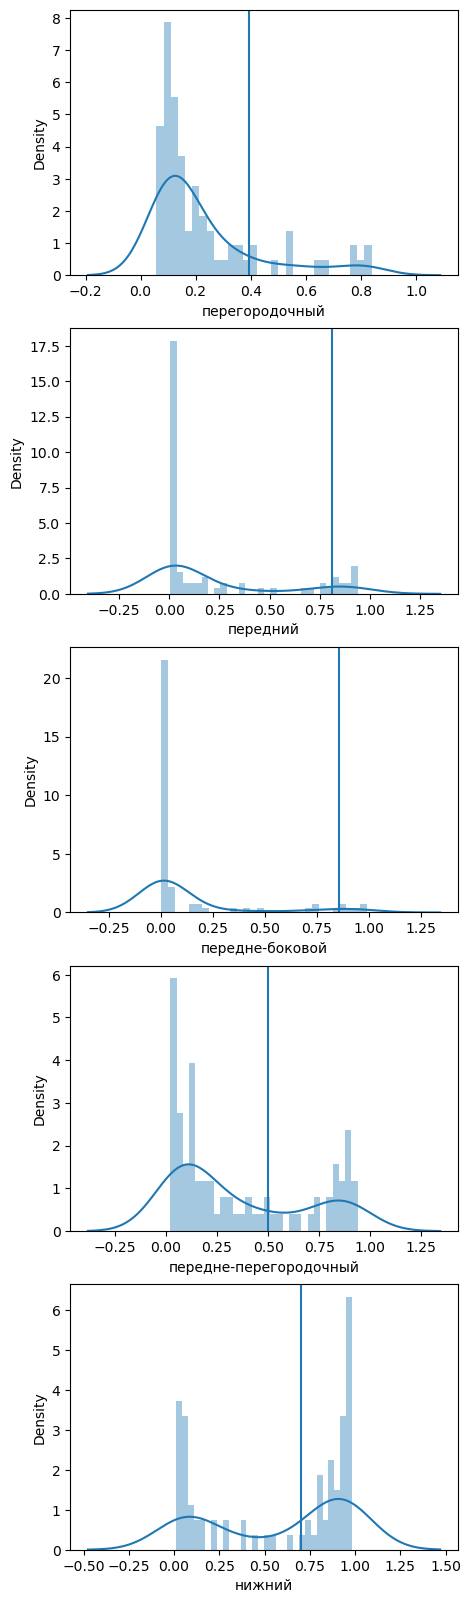

In [783]:
counts = train_gts.drop(columns=['record_name']).sum(axis=0) / len(train_gts)
proba_abnorm = proba[(proba['норма'] != proba.max(axis=1)) & (proba['норма'] < 0.5)]
counts

trashes = {
    'перегородочный': 0.4,
    'передний': 0.75,
    'передне-боковой': 0.75,
    'передне-перегородочный': 0.5,
    'нижний': 0.65,
}

fig, axis = plt.subplots(5, 1, figsize=(5, 20))
idx = 0
for t in trashes.keys():
#     t = 'перегородочный'
    sns.distplot(proba_abnorm[t], bins=30, ax=axis[idx])

    q = 1 - counts[t] * len(proba) / len(proba_abnorm)
    axis[idx].axvline(proba_abnorm[t].quantile(q))
    print(t, proba_abnorm[t].quantile(q), counts[t], q)
    idx += 1

In [695]:
answer.drop(columns=['record_name']).sum(axis=0) / len(answer)

перегородочный            0.024499
передний                  0.026726
боковой                   0.044543
передне-боковой           0.013363
передне-перегородочный    0.055679
нижний                    0.109131
норма                     0.804009
dtype: float64

In [696]:
train_gts.drop(columns=['record_name']).sum(axis=0) / len(train_gts)

перегородочный            0.027606
передний                  0.026178
боковой                   0.000952
передне-боковой           0.012375
передне-перегородочный    0.056640
нижний                    0.103760
норма                     0.802475
dtype: float64